# Random forest DMS

This script runs the random forest model on the data from the differences in fitness effects: deltaS_weak (S_weak - S_opt)

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from IPython.display import HTML

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from statistics import mean

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from rfpimp import permutation_importances
from sklearn.base import clone 

from sklearn import tree
import graphviz
from sklearn.tree import _tree
import sklearn
sklearn.__version__

In [2]:
dataset = pd.read_csv('../../Data/Complete_datasets/dataset_diffNorm_ara0.2_ara0.01_index_differences.txt', sep='\t')
dataset

,Position,WT_Residue,Residue,mean_sel_coeff,Arabinose,mean_sel_coeff_2,Arabinose_2,diffNormScore,Mean_ddG_stab_HET,Mean_ddG_int_HM_A_B,...,recognition_factors,refractivity,relative_mutability_ala100_dayhoff,retention_coefficient_hfba_browne,retention_coefficient_ph2.1_meek,retention_coefficient_ph7.4_meek,retention_coefficient_tfa_browne,total_beta_strand_lifson,transmembrane_tendency_zhao,levy_propensity
0,2,E,*,-0.111687,0.2,-0.042169,0.01,0.069518,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,E,A,0.078380,0.2,0.364839,0.01,0.286459,NaN,NaN,...,0.0,-12.92,-2.0,11.4,7.4,17.4,14.4,0.31,3.28,0.7955
2,2,E,C,0.072816,0.2,0.386025,0.01,0.313209,NaN,NaN,...,11.0,18.51,-82.0,-6.8,5.3,10.1,-2.1,0.55,2.60,1.8265
3,2,E,D,0.070843,0.2,0.131240,0.01,0.060397,NaN,NaN,...,3.0,-5.26,4.0,4.7,4.7,8.7,4.2,-0.13,-0.37,0.0408
4,2,E,E,0.000328,0.2,0.003674,0.01,0.003346,NaN,NaN,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612,78,N,S,0.053429,0.2,0.062348,0.01,0.008919,-0.05281,0.0,...,13.0,-6.93,-14.0,-0.7,-2.1,0.4,1.6,0.22,1.09,0.4069
1613,78,N,T,0.055354,0.2,0.066695,0.01,0.011341,0.01204,0.0,...,-1.0,-2.27,-37.0,3.9,3.1,1.9,6.5,0.52,1.30,0.3724
1614,78,N,V,0.040449,0.2,0.036648,0.01,-0.003801,0.17377,0.0,...,-5.0,0.64,-60.0,4.9,4.9,1.9,9.2,1.21,3.08,1.0292
1615,78,N,W,0.038840,0.2,-0.087122,0.01,-0.125962,-0.11735,0.0,...,10.0,29.25,-116.0,20.6,19.7,14.1,22.0,0.94,3.15,1.0618


In [4]:
# Remove stop codons and rows that are not present in the PDB structure
dataset = dataset[(dataset['Residue'] != '*') & 
                  (pd.notna(dataset['Mean_ddG_stab_HET'])) &
                  (pd.notna(dataset['diffNormScore']))
                 ]

df = dataset.drop(['Entropy','Position','WT_Residue', 'Residue', 'Arabinose',
                   'Secondary_structure','Solvent_accessibility', 'mean_sel_coeff', 
                   'mean_sel_coeff_2', 'Arabinose_2'],axis=1)

In [5]:
df

,diffNormScore,Mean_ddG_stab_HET,Mean_ddG_int_HM_A_B,Mean_ddG_int_HM_A_C,Mean_ddG_int_HM_A_D,rSASA,alpha_helix_chou,alpha_helix_deleage,alpha_helix_levitt,aminoacid_composition_swissprot_bairoch,...,recognition_factors,refractivity,relative_mutability_ala100_dayhoff,retention_coefficient_hfba_browne,retention_coefficient_ph2.1_meek,retention_coefficient_ph7.4_meek,retention_coefficient_tfa_browne,total_beta_strand_lifson,transmembrane_tendency_zhao,levy_propensity
421,-0.000129,0.00000,0.0,0.00000,0.0,1.07,0.00,0.000,0.00,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0000
422,-0.022686,0.08217,0.0,-0.07334,0.0,1.07,-0.72,-0.523,-0.18,-6.88,...,11.0,31.43,-80.0,-18.2,-2.1,-7.3,-16.5,0.24,-0.68,1.0310
423,-0.139569,0.42867,0.0,-0.03732,0.0,1.07,-0.41,-0.565,-0.25,-2.80,...,3.0,7.66,6.0,-6.7,-2.7,-8.7,-10.2,-0.44,-3.65,-0.7547
424,-0.212631,0.12224,0.0,-0.14038,0.0,1.07,0.09,0.015,0.15,-1.50,...,0.0,12.92,2.0,-11.4,-7.4,-17.4,-14.4,-0.31,-3.28,-0.7955
425,-0.104873,-0.52836,0.0,-0.48634,0.0,1.07,-0.29,-0.294,-0.22,-4.39,...,3.0,25.06,-59.0,10.8,14.0,12.7,11.9,0.33,1.60,1.2665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612,0.008919,-0.05281,0.0,0.00000,0.0,1.16,0.10,-0.033,-0.08,2.50,...,13.0,-6.93,-14.0,-0.7,-2.1,0.4,1.6,0.22,1.09,0.4069
1613,0.011341,0.01204,0.0,0.00000,0.0,1.16,0.16,0.013,-0.08,1.28,...,-1.0,-2.27,-37.0,3.9,3.1,1.9,6.5,0.52,1.30,0.3724
1614,-0.003801,0.17377,0.0,0.00000,0.0,1.16,0.39,0.218,0.01,2.81,...,-5.0,0.64,-60.0,4.9,4.9,1.9,9.2,1.21,3.08,1.0292
1615,-0.125962,-0.11735,0.0,0.00000,0.0,1.16,0.41,0.318,0.09,-2.98,...,10.0,29.25,-116.0,20.6,19.7,14.1,22.0,0.94,3.15,1.0618


In [6]:
X = df.drop(['diffNormScore'],axis=1)
Y = df['diffNormScore']

# Normalize all the features to the range of -1 , 1
X = X / X.max()

In [7]:
## Train a random forest model
X_train,X_test,y_train,y_test =train_test_split(X,Y,test_size=0.2, random_state=100)

model_rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100)
model_rf.fit(X_train, y_train) 
pred_train_rf= model_rf.predict(X_train)

print('Mean squared error (train):', np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print('R2 score (train):', r2_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)

print('Mean squared error (test):', np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print('R2 score (test):', r2_score(y_test, pred_test_rf))

Mean squared error (train): 0.046380732377507616
R2 score (train): 0.9086426615856686
Mean squared error (test): 0.12276302664662157
R2 score (test): 0.2550551801728743


In [8]:
## Train the random forest again but adding a random variable
np.random.seed(100)
X['random_var'] = np.random.normal(loc = 0, scale = 1, size = X.shape[0])

X_train,X_test,y_train,y_test =train_test_split(X,Y,test_size=0.2, random_state = 100)

model_rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100)
model_rf.fit(X_train, y_train) 
pred_train_rf= model_rf.predict(X_train)

print('Mean squared error (train):', np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print('R2 score (train):', r2_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)

print('Mean squared error (test):', np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print('R2 score (test):', r2_score(y_test, pred_test_rf))

Mean squared error (train): 0.0464853803248438
R2 score (train): 0.9082299409202684
Mean squared error (test): 0.12256718508749456
R2 score (test): 0.2574300774077466


Use cross-validation on this preliminary model

In [12]:
cross_val_n = 5
print('Five-fold cross validation of the random forest model:')
cross_validations = cross_val_score(estimator = model_rf, X = X_train, y = y_train, cv=cross_val_n , scoring = r2)
print(cross_validations)
print(np.mean(cross_validations), np.std(cross_validations) / np.sqrt(cross_val_n))
print('------')

Five-fold cross validation of the random forest model:
[0.42026654 0.26757304 0.37548971 0.17737478 0.28976546]
0.3060939061359988 0.03803695892008682
------


In [13]:
cross_validations = cross_val_score(estimator = model_rf, X = X_train, y = y_train, cv=5, scoring = r2)
print(cross_validations)

[0.42026654 0.26757304 0.37548971 0.17737478 0.28976546]


In [14]:
## Check cross-validation accuracy
cross_validations_pred = cross_val_predict(estimator = model_rf, X = X_train, y = y_train, cv=5)

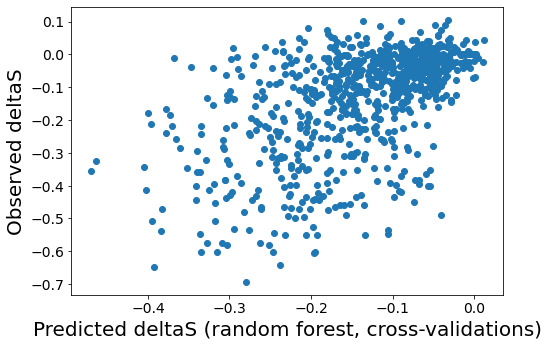

In [16]:
%matplotlib inline
## Scatterplot of the random forest predictions 
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.scatter(cross_validations_pred, y_train)
ax.set_xlabel('Predicted deltaS (random forest, cross-validations)', fontsize = 20)
ax.set_ylabel('Observed deltaS', fontsize = 20)
cross_validations_pred[1, ]
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.show()

Figures for the accuracy of the predictions and selecting the best variables

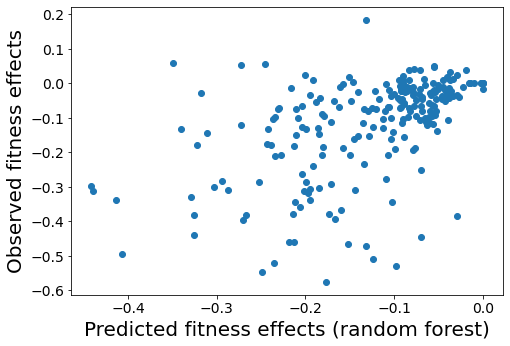

In [17]:
%matplotlib inline
## Scatterplot of the random forest predictions 
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.scatter(pred_test_rf, y_test)
ax.set_xlabel('Predicted fitness effects (random forest)', fontsize = 20)
ax.set_ylabel('Observed fitness effects', fontsize = 20)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.show()

In [18]:
## Save the corresponding files for predictions on validation set and test set
## Results with all variables
df_pred_test = pd.DataFrame(list(zip(y_test,  pred_test_rf)), columns = ['test_data', 'pred_data'])
df_pred_test.to_csv('../../Data/Random_forest_results/pred_rf_allVariables.txt', sep = '\t')

## Results of predictions in the cross-validation
df_pred_crossval = pd.DataFrame(list(zip(y_train, cross_validations_pred)), columns = ['test_data', 'pred_data'])
df_pred_crossval.to_csv('../../Data/Random_forest_results/crossval_rf_allVariables.txt', sep = '\t')



## Feature selection

In [9]:
# Define a function to use permutation to estimate relative importances
def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

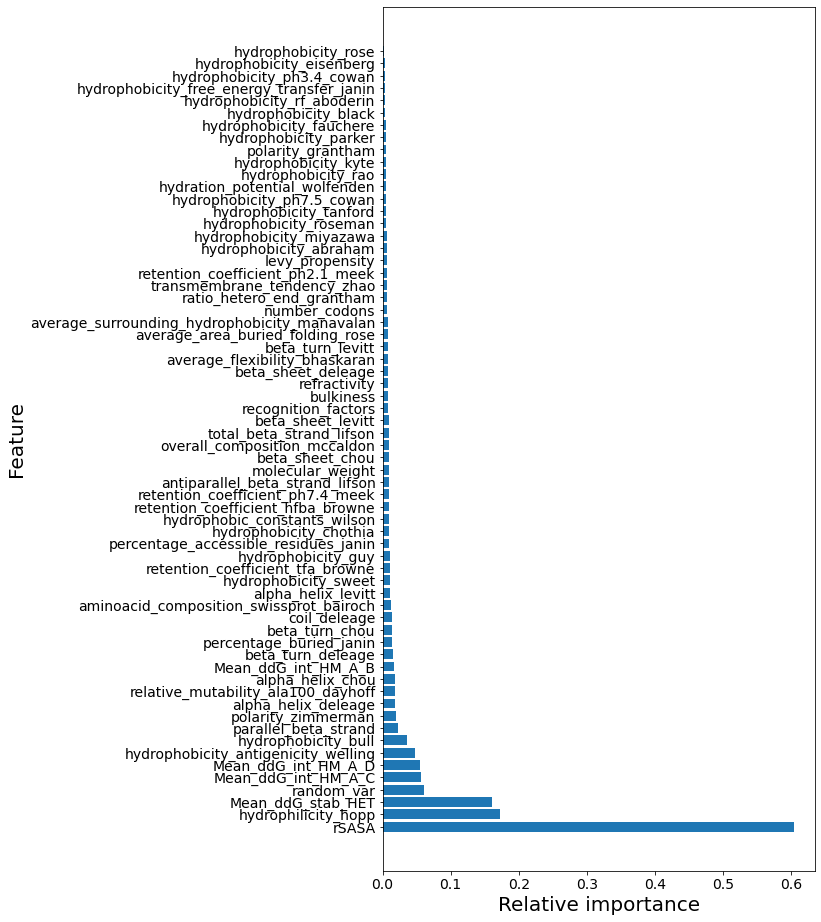

In [19]:
# Use permutation to estimate relative importances
perm_imp_rfpimp = permutation_importances(model_rf, X_train, y_train, r2)

%matplotlib inline
fig = plt.figure()

ax = fig.add_axes([0,0,1,3])
ax.barh(list(perm_imp_rfpimp.index), perm_imp_rfpimp['Importance'])
ax.set_xlabel('Relative importance', fontsize = 20)
ax.set_ylabel('Feature', fontsize = 20)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.show()


In [20]:
best_features = perm_imp_rfpimp[perm_imp_rfpimp['Importance'] >= perm_imp_rfpimp['Importance']['random_var']]
best_features

,Importance
Feature,
rSASA,0.604499
hydrophilicity_hopp,0.172707
Mean_ddG_stab_HET,0.160742
random_var,0.060335


In [21]:
new_X = X[list(best_features.index)]

# Train a new random forest with the selected variables and the random variable
X_train,X_test,y_train,y_test =train_test_split(new_X,Y,test_size=0.2, random_state = 100)

model_rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100)
model_rf.fit(X_train, y_train) 
pred_train_rf= model_rf.predict(X_train)

print('Mean squared error (train):', np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print('R2 score (train):', r2_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)

print('Mean squared error (test):', np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print('R2 score (test):', r2_score(y_test, pred_test_rf))


Mean squared error (train): 0.043672119331418235
R2 score (train): 0.9190015384427834
Mean squared error (test): 0.11704815409855217
R2 score (test): 0.3227982552675691


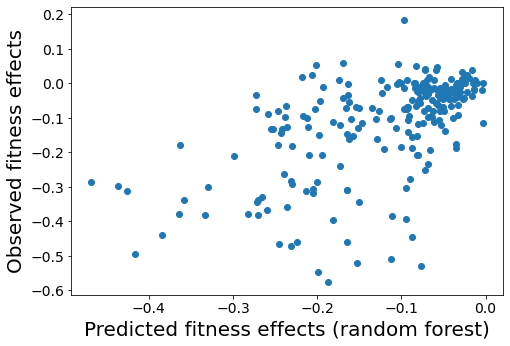

In [22]:
%matplotlib inline
## Scatterplot of the random forest predictions 
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.scatter(pred_test_rf, y_test)
ax.set_xlabel('Predicted fitness effects (random forest)', fontsize = 20)
ax.set_ylabel('Observed fitness effects', fontsize = 20)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.show()

In [23]:
# Cross-validation
cross_val_n = 5

print('Five-fold cross validation of the random forest model:')
cross_validations = cross_val_score(estimator = model_rf, X = X_train, y = y_train, cv=cross_val_n, scoring = r2)
print(cross_validations)
print(np.mean(cross_validations), np.std(cross_validations) / np.sqrt(cross_val_n))
print('------')

cross_validations_pred = cross_val_predict(estimator = model_rf, X = X_train, y = y_train, cv=cross_val_n)

Five-fold cross validation of the random forest model:
[0.46892075 0.3533313  0.48305044 0.27528306 0.35626441]
0.38736999023841046 0.03492560445220283
------


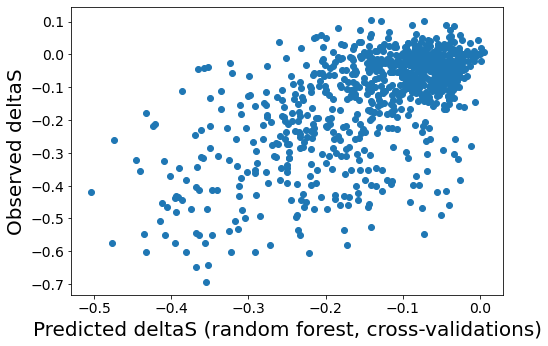

In [24]:
%matplotlib inline
## Scatterplot of the random forest predictions 
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.scatter(cross_validations_pred, y_train)
ax.set_xlabel('Predicted deltaS (random forest, cross-validations)', fontsize = 20)
ax.set_ylabel('Observed deltaS', fontsize = 20)
cross_validations_pred[1, ]
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.show()

In [25]:
# Since this is a simpler model, we can test relative importance by leaving one
# variable out and retraining
# Function from https://explained.ai/rf-importance/index.html#intro
def dropcol_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    rf_.random_state = 100
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 100
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    I = pd.DataFrame(
            data={'Feature':X_train.columns,
                  'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    return I

In [26]:
importances_drop_col = dropcol_importances(model_rf, X_train, y_train)

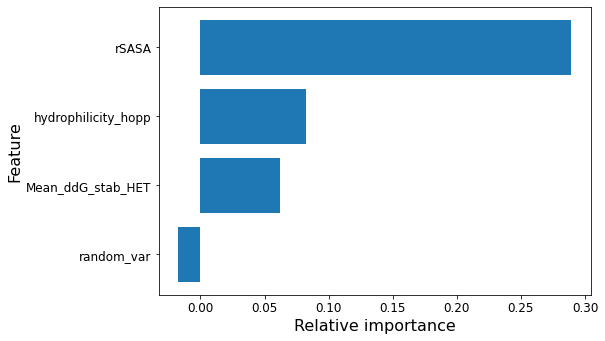

In [27]:
%matplotlib inline
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.barh(list(importances_drop_col.index), importances_drop_col['Importance'])
ax.set_xlabel('Relative importance', fontsize = 16)
ax.set_ylabel('Feature', fontsize = 16)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

plt.show()

In [28]:
### Save the tables
## Relative importances permutation (all)
perm_imp_rfpimp.to_csv('../../Data/Random_forest_results/model_diffFit_permImportances_allVariables.txt', sep = '\t')

## Predictions for test set(best variables)
df_pred_test_best = pd.DataFrame(list(zip(y_test,  pred_test_rf)), columns = ['test_data', 'pred_data'])
df_pred_test_best.to_csv('../../Data/Random_forest_results/pred_rf_bestVariables.txt', sep = '\t')

## Predictions for cross-validation (best variables)
df_pred_crossval_best = pd.DataFrame(list(zip(y_train, cross_validations_pred)), columns = ['test_data', 'pred_data'])
df_pred_crossval_best.to_csv('../../Data/Random_forest_results/crossval_rf_bestVariables.txt', sep = '\t')

## Relative importances drop column (best variables)
importances_drop_col.to_csv('../../Data/Random_forest_results/model_diffFit_dropCol_bestVariables.txt', sep = '\t')
